## BERT 이용 네이버 영화 리뷰 감성분석

- 발표일 : 2021/05/26
- 작성자 : Soyoung Cho

In [2]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup

import pandas as pd
import numpy as np
import random
import time
import datetime

In [3]:
train = pd.read_csv("data/ratings_train.txt", sep='\t')
test = pd.read_csv("data/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


탭을 이용해 구분하여 데이터프레임으로 읽어옵니다. 학습 데이터 75%, 테스트 데이터 25%의 데이터가 구분되어 있습니다.

In [4]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Part 1. 전처리

### BERT Input representation

![](https://blog.kakaocdn.net/dn/WFCfe/btqBWZ40Gmc/6FkuwsAGN9e7Uudmi03k4k/img.png)

- BERT에서는 문장 앞에 [CLS]라는 스페셜 토큰을 붙여 문장의 시작임을 알립니다.
  - [CLS] 심볼은 Classification을 뜻합니다. Fine-tuning시 출력에서 이 위치의 값을 사용하여 분류를 합니다.
- 문장 종료는 [SEP]라는 스페셜 토큰으로 모델에게 알립니다.
  - [SEP] 심볼은 Seperation을 뜻합니다. 두 문장을 구분하는 역할을 합니다.
  - 이 예제에서는 문장이 하나이므로 [SEP]도 하나만 넣습니다.

In [5]:
sentences = ["[CLS] " + str(document) + " [SEP]" for document in train.document]

In [6]:
sentences[:5]

['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]']

### Tokenize

- BERT는 형태소분석으로 토큰을 분리하지 않습니다. **WordPiece**라는 통계적인 방식을 사용합니다.
- 한 단어 내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듭니다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있습니다. 또한 신조어 같이 사전에 없는 단어(OOV)를 처리하기도 좋습니다. 
- 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용합니다. 그래서 한글도 처리가 가능합니다.
- 아래의 결과에서 ## 기호는 앞 토큰과 이어진다는 표시입니다.

In [7]:
# 라벨 추출
labels = train['label'].values
labels

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in sentences]
print(tokenized_texts[0])

['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']


### Padding

보통 딥러닝 모델에는 토큰 자체를 입력으로 넣을 수 없습니다. 임베딩 레이어에는 토큰을 숫자로 된 인덱스로 변환하여 사용해야 합니다. BERT의 토크나이저는 {단어토큰:인덱스}로 구성된 단어사전을 가지고 있습니다. 이를 참조하여 토큰을 인덱스로 바꿔줍니다.

In [9]:
MAX_LEN = 128 # 입력 토큰의 최대 시퀀스 길이
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts] # 토큰을 숫자 인덱스로 변환

In [10]:
print(input_ids[0])

[101, 9519, 9074, 119005, 119, 119, 9708, 119235, 9715, 119230, 16439, 77884, 48549, 9284, 22333, 12692, 102]


한 문장씩 문장별 토큰을 각각의 숫자 ID로 변환합니다.

In [11]:
print("첫 번째 문장의 첫 번째 토큰 : ", tokenized_texts[0][0])
print("두 번째 문장의 첫 번째 토큰 : ", tokenized_texts[1][0])
print("첫 번째 문장의 마지막 토큰 : ", tokenized_texts[0][-1])
print("두 번째 문장의 마지막 토큰 : ", tokenized_texts[1][-1])

첫 번째 문장의 첫 번째 토큰 :  [CLS]
두 번째 문장의 첫 번째 토큰 :  [CLS]
첫 번째 문장의 마지막 토큰 :  [SEP]
두 번째 문장의 마지막 토큰 :  [SEP]


In [12]:
print("첫 번째 문장의 첫 번째 토큰 id : ", input_ids[0][0])
print("두 번째 문장의 첫 번째 토큰 id : ", input_ids[1][0])
print("첫 번째 문장의 마지막 토큰 id : ", input_ids[0][-1])
print("두 번째 문장의 마지막 토큰 id : ", input_ids[1][-1])

첫 번째 문장의 첫 번째 토큰 id :  101
두 번째 문장의 첫 번째 토큰 id :  101
첫 번째 문장의 마지막 토큰 id :  102
두 번째 문장의 마지막 토큰 id :  102


동일한 토큰은 동일 id를 가지는 것을 볼 수 있습니다. CLS 토큰은 101의 ID, SEP 토큰은 102의 ID를 갖네요.

In [13]:
# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

In [14]:
input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

케라스의 함수 pad_sequences를 이용하여 문장에서 남는 부분을 패딩 0으로 채워줍니다. pad_sequences 함수는 문장의 길이를 맞출 수 있도록 패딩해주는 함수입니다.
인자에 대해 간단히 살펴보면 다음과 같습니다.
- sequences : 시퀀스 리스트이며, 각 시퀀스는 integer 리스트입니다.
- maxlen : 시퀀스의 최대 길이입니다. 시퀀스가 이 최대 길이를 초과하면 시퀀스를 자릅니다. maxlen을 명시하지 않으면 가장 긴 시퀀스에 맞춰집니다.
- truncating: 시퀀스가 maxlen을 초과하는 경우, 초과하는 값을 앞에서 자를지, 뒤에서 잘을지 명시합니다. defaults to 'pre'.
- padding : 패딩을 앞에 채울지, 뒤에 채울지 의미합니다.우리는 시퀀스 뒤에 패딩하기 위해 'post'라고 적어줍니다. defaults to 'pre'.
- value : 패딩을 채울 값이고, default는 0입니다.


### Attention Mask

- 앞에서 패딩은 0으로 했었기에, 0보다 큰지 작은지를 비교하여 패딩과 유의미한 토큰을 구분할 수 있습니다.
- 패딩을 마스크하는 목적은 학습속도를 높이기 위함입니다.
- PAD 토큰은 실질적인 의미를 가진 토큰이 아니기에, 이에 대해서는 연산을 하지 않도록 마스킹(Masking)을 하여 어텐션에서 제외하도록 하는 것입니다.
- 이렇게 실 데이터가 있는 곳과 padding이 있는 곳을 attention에게 알려줄 수 있습니다.

In [15]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq] # 패딩은 0으로 했었음. 그 외 숫자는 0보다 큼. True일 경우 1.
    attention_masks.append(seq_mask) # 각 시퀀스 마스크 결과 append

In [16]:
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Split train , valid set

- train 데이터를 train set과 valid set으로 구분합니다.
- input과 mask가 뒤섞이지 않도록 random_state를 일정하게 고정합니다.

In [17]:
# input id, label를 train과 valid로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=42, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 train과 valid로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.1)

### Convert to torch.tenser

In [18]:
# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs) # 시퀀스를 토큰 ID로 표현
train_labels = torch.tensor(train_labels) # 긍/부정
train_masks = torch.tensor(train_masks) # 패딩 마스크 (attention mask)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

In [55]:
# print(train_inputs[0])
# print(train_labels[0])
# print(train_masks[0])

# print(validation_inputs[0])
# print(validation_labels[0])
# print(validation_masks[0])

### 배치 및 데이터로더 설정
현재 쓰고 있는 GPU의 VRAM에 맞도록 배치사이즈를 설정합니다.
우선 배치사이즈를 크게 넣어보고 VRAM 부족 메시지가 나오면 8의 배수 중 더 작은 것으로 줄여나가는 것이 일반적인 방법입니다.

In [19]:
BATCH_SIZE = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈만큼 데이터를 가져옵니다.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

- TensorDataset 클래스 : Dataset을 상속한 클래스로,  학습 데이터 X와 레이블 Y를 묶어 놓는 컨테이너입니다. TensorDataset을 DataLoader에 전달하면 for 루프에서 데이터의 일부분만 간단히 추출할 수 있습니다. TensorDataset에는 텐서만 전달할 수 있으며, Variable은 전달할 수 없으니 주의합니다. (출처 : https://truman.tistory.com/223)

- RandomSampler : 랜덤하게 데이터를 추출합니다.

- DataLoader 클래스 : 데이터셋을 배치 단위로 쪼개어 학습 시 반복문 안에서 데이터를 공급해 데이터를 쉽게 로드할 수 있습니다.

- SequentialSampler 클래스 : 데이터를 순차적으로 추출합니다. Always in the same order.

### Test셋 전처리

- 위의 train, valid 데이터셋 전처리와 동일합니다.
- train 전처리시 함께 처리해도 무방합니다.

In [20]:
sentences = ["[CLS] " + str(document) + " [SEP]" for document in test.document]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

---
## Part 2. 모델 학습

### GPU 체크 및 할당

In [21]:
# 디바이스 설정

n_devices = torch.cuda.device_count()

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    for i in range(n_devices):
        print("Device",i,":", torch.cuda.get_device_name(i))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
Device 0 : NVIDIA GeForce RTX 3080


C:\Users\user\anaconda3\envs\torch37\lib\site-packages\torch\cuda\__init__.py:106: UserWarning: 
NVIDIA GeForce RTX 3080 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


### 분류를 위한 BERT 모델 생성

- Huggning Face가 제공하는 BertForSequenceClassification() 함수를 이용하여 쉽게 구현할 수 있습니다.
- 이진분류이기 때문에 num_labels는 2로 둡니다.

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

![](http://www.mccormickml.com/assets/BERT/padding_and_mask.png)

Pre-training을 마친 BERT는 다양한 문제로 전이학습(Fine-tuning)이 가능합니다. 여기서는 위의 그림과 같이 한 문장을 분류하는 방법을 사용합니다. 영화리뷰 문장이 입력으로 들어가면, 긍정/부정으로 구분합니다. 모델의 출력에서 [CLS] 위치인 첫 번째 토큰에 새로운 레이어를 붙여서 파인튜닝을 합니다.

### 하이퍼파라미터 설정

In [23]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 2

# 총 훈련 스텝 = 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

- transformers에서 제공하는 옵티마이저 중 AdamW를 사용합니다.
- Learning Rate Scheduler는 transformers에서 제공하는 것을 사용합니다.

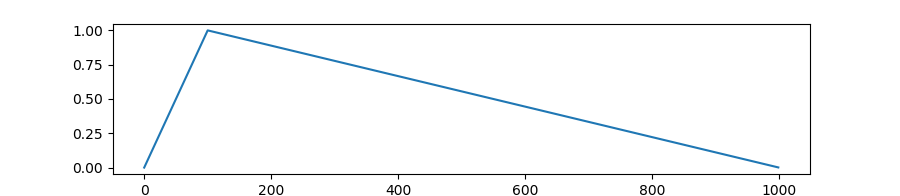

#### Batch, Epoch, Step 개념 복습
- Batch : 한 번에 몇 개의 데이터씩 처리할지. mini-batch 그 개념. 병렬적으로 처리되는 각 데이터 뭉탱이.
- Epoch : 전체 데이터에 대해 한 바퀴 도는 것. 일반적으로 1 에폭이 끝나면 데이터를 랜덤으로 섞는다.
- Step : 한 배치가 도는 것. 1 batch 도는 것 = 1 step. len(data_loader)를 하면 배치 개수를 구할 수 있다.
  - Batch_size, epoch을 정해주면 step은 자동적으로 계산되기에 사실 hyperparameter는 아니다.

### 기타 함수

In [24]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

### 학습 실행

- 데이터로더에서 배치만큼 가져온 후 forward, backward pass를 수행합니다.
- gradient update는 명시적으로 하지 않고, 위에서 로드한 optimizer를 활용합니다.

#### model 파라미터
- attention_mask : 패딩 토큰 인덱스에 attention을 수행하는 것을 방지하기 위해 마스킹한 인덱스들입니다
  - 0과 1로 표기하며 마스킹 되지 않았다면 (패딩 토큰이 아닌 경우) 1, 패딩 토큰인 경우 0으로 합니다.
- token_type_ids : 입력 시퀀스가 두 문장으로 구성될 경우 첫 번째 문장을 0으로, 두 번째 문장을 1로 명시해줍니다.
  - 우리는 문장 1개만을 이용하므로 None이라 설정합니다.
- labels : 사이즈는 (batch_size,)이며, 이를 이용해 시퀀스 loss를 계산합니다.
  - labels 인덱스들은 클래스 개수에 따라 0부터 클래스개수-1의 숫자로 표현되어야 합니다.
  - config.num_labels 가 1인 경우, regression loss가 계산되며 (Mean-Square loss), config.num_labels가 1보다 큰 경우, 즉 binary classification ~ multi-class classification인 경우 Cross-Entropy를 이용해 loss가 계산됩니다.
  - 우리는 모델을 불러올 때 (model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
) num_labels=2로 주었었습니다. 긍정/부정을 분류하는 이진 분류 문제이기 때문입니다. 따라서 크로스 엔트로피로 계산됩니다.

#### Gradient Clipping (그래디언트 클리핑)
- 주로 RNN계열에서 gradient vanishing이나 gradient exploding이 많이 발생하는데, gradient exploding을 방지하여 학습의 안정화를 도모하기 위해 사용하는 방법입니다.
- clipping이란 단어에서 유추할 수 있듯이 gradient가 일정 threshold를 넘어가면 clipping을 해줍니다. clipping은 gradient의 L2norm (norm이지만 보통 L2 norm 사용)으로 나눠주는 방식으로 하게 된다고 합니다.
- 출처 : https://sanghyu.tistory.com/87

#### model.eval()
- train 할 때와 evaluate 해야 할 때 다르게 동작해야 하는 레이어에는 대표적으로 Dropout Layer와 BatchNorm Layer가 있습니다. 
- .eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수라고 합니다.
- evaluation/validation 과정에선 보통 model.eval()과 torch.no_grad()를 함께 사용합니다.
- 출처 : https://bluehorn07.github.io/2021/02/27/model-eval-and-train.html

In [25]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

In [68]:
# 에폭 수만큼 반복
for epoch in range(epochs):
    
    # ========================================
    #               1. Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    
    # 시작 시간 설정
    start_time = time.time()
    
    # 로스 초기화
    total_loss = 0
    
    # 훈련모드로 변경
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시 (step 500번마다 출력)
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - start_time)
            print('Batch {:>5,}  of  {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        # 배치를 GPU에 올림
        batch = tuple(b.to(device) for b in batch)
        
        # 배치에서 데이터 추출 (input, mask, label 순으로 넣었었음)
        b_input_ids, b_input_mask, b_labels = batch
        
        # forward 수행
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                       token_type_ids=None,
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs.loss # outputs[0]
        
        # 총 로스 계산
        total_loss += loss.item()
        
        # Backward 수행으로 그래디언트 계산 (Back-propagation)
        loss.backward()
        
        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0) # 예제 코드에서는 1.0이었음
        
        # 그래디언트를 이용해 가중치 파라미터를 lr만큼 업데이트
        optimizer.step()
        
        # 스케줄러로 학습률 감소
        scheduler.step()
        
        # 그래디언트 초기화
        ## (호출시 경사값을 0으로 설정. 이유 : 반복 때마다 기울기를 새로 계산하기 때문)
        model.zero_grad()
    
    # 1 에폭이 끝나면 평균 train 로스 계산 (전체 loss / 배치 수)
    avg_train_loss = total_loss / len(train_dataloader)
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - start_time)))
    
    # ========================================
    #               2. Validation
    # ========================================
    
    # 1 에폭이 끝나면 validation 시행
    
    print("")
    print("Running Validation...")
    
    # 시작 시간 설정
    start_time = time.time()
    
    # 평가 모드로 변경
    model.eval()
    
    # 변수 초기화
    total_valid_accuracy = 0
    nb_valid_steps = 0
    
    # valid 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        
        # 배치를 GPU에 넣음
        batch = tuple(b.to(device) for b in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함!
        with torch.no_grad():
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함 (train할 때는 loss, validation할 때는 logits)
        ## logits은 softmax를 거치기 전의 classification score를 반환합니다. shape: (batch_size, config.num_labels)
        logits = outputs.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        valid_accuracy = flat_accuracy(logits, label_ids)
        total_valid_accuracy += valid_accuracy

    print("  Accuracy: {0:.2f}".format(total_valid_accuracy/len(validation_dataloader)))
    print("  Validation took: {:}".format(format_time(time.time() - start_time)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
Batch   500  of  4,219. Elapsed: 0:08:01.
Batch 1,000  of  4,219. Elapsed: 0:16:03.
Batch 1,500  of  4,219. Elapsed: 0:24:04.
Batch 2,000  of  4,219. Elapsed: 0:32:04.
Batch 2,500  of  4,219. Elapsed: 0:40:05.
Batch 3,000  of  4,219. Elapsed: 0:48:05.
Batch 3,500  of  4,219. Elapsed: 0:56:05.
Batch 4,000  of  4,219. Elapsed: 1:04:05.

  Average training loss: 0.28
  Training epcoh took: 1:07:35

Running Validation...
  Accuracy: 0.86
  Validation took: 0:02:25

======== Epoch 2 / 2 ========
Training...
Batch   500  of  4,219. Elapsed: 0:08:00.
Batch 1,000  of  4,219. Elapsed: 0:16:00.
Batch 1,500  of  4,219. Elapsed: 0:24:00.
Batch 2,000  of  4,219. Elapsed: 0:32:34.
Batch 2,500  of  4,219. Elapsed: 0:41:35.
Batch 3,000  of  4,219. Elapsed: 0:50:47.
Batch 3,500  of  4,219. Elapsed: 0:59:50.
Batch 4,000  of  4,219. Elapsed: 1:08:30.

  Average training loss: 0.26
  Training epcoh took: 1:12:04

Running Validation...
  Accuracy: 0.87
  Validatio

---
## Part 3. 모델 테스트 (test set 이용)

In [ ]:
# torch.save(model.state_dict(), "model.pth")

In [26]:
model.load_state_dict(torch.load("model.pth"))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [27]:
#시작 시간 설정
start_time = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - start_time)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(b.to(device) for b in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/len(test_dataloader)))
print("Test took: {:}".format(format_time(time.time() - start_time)))

  Batch   100  of  1,563.    Elapsed: 0:01:58.
  Batch   200  of  1,563.    Elapsed: 0:02:29.
  Batch   300  of  1,563.    Elapsed: 0:03:00.
  Batch   400  of  1,563.    Elapsed: 0:03:31.
  Batch   500  of  1,563.    Elapsed: 0:04:01.
  Batch   600  of  1,563.    Elapsed: 0:04:32.
  Batch   700  of  1,563.    Elapsed: 0:05:03.
  Batch   800  of  1,563.    Elapsed: 0:05:34.
  Batch   900  of  1,563.    Elapsed: 0:06:05.
  Batch 1,000  of  1,563.    Elapsed: 0:06:36.
  Batch 1,100  of  1,563.    Elapsed: 0:07:07.
  Batch 1,200  of  1,563.    Elapsed: 0:07:39.
  Batch 1,300  of  1,563.    Elapsed: 0:08:10.
  Batch 1,400  of  1,563.    Elapsed: 0:08:41.
  Batch 1,500  of  1,563.    Elapsed: 0:09:12.

Accuracy: 0.87
Test took: 0:09:31


---
## Part 4. 새로운 문장 테스트

In [28]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [29]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [30]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

[[-1.2956648  1.3821511]]
1


In [31]:
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

print(logits)
print(np.argmax(logits))

[[ 2.9581914 -3.235781 ]]
0


In [32]:
logits = test_sentences(['주연배우가 아깝다. 영화노잼...'])

print(logits)
print(np.argmax(logits))

[[ 2.720135  -2.9258687]]
0


- http://yonghee.io/bert_binary_classification_naver/
 - https://colab.research.google.com/drive/1tIf0Ugdqg4qT7gcxia3tL7und64Rv1dP#scrollTo=I3vlyUJuVRo5  